final version --> less features

In [1]:
import sys
sys.path.append('../../')

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from modules import machine_learning_utils as mlu

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [3]:
df = pd.read_pickle("../../data_lake/output/train_eng.pkl")
val = pd.read_pickle("../../data_lake/output/val_eng.pkl")

In [4]:
df = df.drop(columns=['card1', 'card2', 'card3','card5', 'addr1', 'addr2','id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29','id_35', 'id_36', 'id_37', 'id_38','id_34','M4','id_32','num_transaction_per_time',
       'multi_transaction_per_time'])

In [5]:
val = val.drop(columns=['card1', 'card2', 'card3','card5', 'addr1', 'addr2','id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29','id_35', 'id_36', 'id_37', 'id_38','id_34','M4','id_32','num_transaction_per_time',
       'multi_transaction_per_time'])

# 2.0 Training baseline

In [6]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [7]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [8]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [9]:
parameters = {'model__max_depth':[2,4],'model__n_estimators':[100,200,400],'model__learning_rate':[0.05,0.5,0.1]}

In [10]:
model = mlu.model_training(X_train,y_train,numerical_cols,categorical_cols,parameters)

GridSearchCV results...
Mean Train Scores: 
[0.7444873  0.76886349 0.78368838 0.80166903 0.81653567 0.8309453
 0.80793975 0.82953394 0.83621999 0.87093544 0.87591866 0.87591866
 0.76990157 0.7848095  0.79789045 0.81744929 0.83256477 0.85573681]

Mean CV Scores: 
[0.74074954 0.7635468  0.77525756 0.78684413 0.7965613  0.80715086
 0.79207594 0.80278963 0.8056546  0.8212279  0.82409368 0.82409368
 0.76392062 0.77700152 0.78497492 0.79568923 0.80777355 0.81823761]

Best Parameters: 
{'model__learning_rate': 0.5, 'model__max_depth': 4, 'model__n_estimators': 200}



# 3.0 Evaluation baseline

In [11]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [12]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

In [13]:
m = mlu.model_calibration(model,X_val,y_val)

Test results...
Model Test Recall: 0.8342374924653405
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.98      0.84      0.90     19976
         1.0       0.30      0.83      0.44      1659

    accuracy                           0.84     21635
   macro avg       0.64      0.83      0.67     21635
weighted avg       0.93      0.84      0.87     21635

ProductCD: 0.38737825340064524
TransactionAmt: 0.12201507229326762
card4: 0.09608613904658905
P_emaildomain: 0.042228938837015256
R_emaildomain: 0.028458521398126727
id_33: 0.006059232959149198
id_30: 0.004925969590588585
max_c: 0.003084474852694018
max_d: 0.0015023894903973183
device_info_v4: 0.001306944859370005
DeviceType: 0.0009883017162373915
browser_enc: 0.00026187599883253666
card6: 3.1356909597216215e-05


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(add_indicator=True,
                                                                                    estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                  random_state=1),
                                                                                    random_state=1)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['TransactionAmt', 'max_c', 'max_d'], dtype='object')),
                                                 ('categorical_preproce

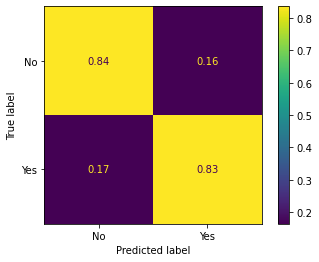

In [14]:
mlu.model_evaluation(m.base_estimator, X_val, y_val)

In [20]:
df.sample(3)

,isFraud,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_30,id_33,DeviceType,max_c,max_d,browser_enc,device_info_v4
50551,0,30.000,H,mastercard,credit,gmail.com,gmail.com,iOS_11_2_1,2208x1242,mobile,2.0,157.708328,safari,ios
103308,1,19.455,C,visa,debit,hotmail.com,hotmail.com,nan,nan,mobile,3.0,179.833328,safari,other
45835,0,50.000,R,visa,debit,gmail.com,gmail.com,iOS_11_2_1,1334x750,mobile,1.0,0.708333,safari,ios


# 4.0 Model Output

In [15]:
with open('../../data_lake/output/trained_model_v1.pkl','wb') as file:
    pickle.dump(m.base_estimator, file)